   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/tmp/ipython-input-666996741.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: muhammadwasea04 (muhammadwasea04-no) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.285900,0.289178,0.913500,0.914101
2,0.231600,0.290409,0.914000,0.914947
3,0.108800,0.323857,0.914000,0.914947


📊 Evaluation Results: {'eval_loss': 0.2891775071620941, 'eval_accuracy': 0.9135, 'eval_f1': 0.9141005571190657, 'eval_runtime': 14.4988, 'eval_samples_per_second': 137.943, 'eval_steps_per_second': 8.621, 'epoch': 3.0}


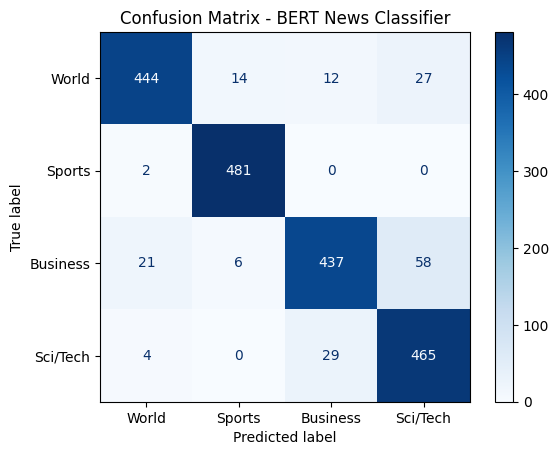

Device set to use cuda:0


[{'label': 'LABEL_3', 'score': 0.9658050537109375}]
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://11dafa21e92ce791d1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)



📌 Summary & Insights:
- Final Accuracy: 0.913
- Final F1 Score: 0.914
- Confusion Matrix shows which categories are often confused.
- Model performs strongly overall (>91% accuracy).
- Slight class imbalance may cause misclassification between Business and Sci/Tech.
- With more training data (full 120k samples) and fine-tuning, performance can improve further.


In [1]:
# ============================================================
# Task 1 – News Topic Classifier Using BERT
# Internship: DevelopersHub Corporation
# Author: Muhammad Wasea
# Date: Sept 2025
# ============================================================


# ============================================================
# 1. Install Dependencies
# ============================================================
!pip install torch torchvision torchaudio --quiet
!pip install transformers datasets evaluate --quiet
!pip install gradio matplotlib seaborn scikit-learn --quiet

# ============================================================
# 2. Imports
# ============================================================
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
    pipeline
)
from transformers import DataCollatorWithPadding
from transformers import EarlyStoppingCallback
import evaluate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# ============================================================
# 3. Problem Statement & Dataset
# ==========================================================================================
# Problem: Classify news headlines into 4 categories (World, Sports, Business, Sci/Tech).")
# ==========================================================================================

dataset = load_dataset("ag_news")
print(dataset)

# Example sample
print(dataset["train"][0])

# ============================================================
# 4. Tokenization & Preprocessing
# ============================================================
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True, max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Smaller subsets for faster training (optional in Colab)
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(8000))
test_dataset  = tokenized_datasets["test"].shuffle(seed=42).select(range(2000))


# ============================================================
# 5. Load Model
# ============================================================
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=4)

# ============================================================
# 6. Metrics (Accuracy + F1)
# ============================================================
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy.compute(predictions=preds, references=labels)
    f1_score = f1.compute(predictions=preds, references=labels, average="macro")
    return {"accuracy": acc["accuracy"], "f1": f1_score["f1"]}


# ============================================================
# 7. Training Setup with Early Stopping
# ============================================================

training_args = TrainingArguments(
    output_dir="bert-news-classifier",
    evaluation_strategy="epoch",     # evaluate every epoch
    save_strategy="epoch",           # save every epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,              # allow up to 5, early stopping may cut earlier
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=50,
    load_best_model_at_end=True,     # restore best checkpoint
    metric_for_best_model="accuracy",# use accuracy as primary metric
    greater_is_better=True,
    push_to_hub=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]  # 🔹 stop if no improvement for 2 evals
)

# ============================================================
# 8. Train Model
# ============================================================
trainer.train()


# ============================================================
# 9. Evaluate Model
# ============================================================
results = trainer.evaluate()
print("📊 Evaluation Results:", results)

# Confusion Matrix (Visualization)

preds_output = trainer.predict(test_dataset)
y_true = preds_output.label_ids
y_pred = np.argmax(preds_output.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["World","Sports","Business","Sci/Tech"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - BERT News Classifier")
plt.show()

# ============================================================
# 10. Save Model & Tokenizer
# ============================================================
save_path = "bert_news_model"
trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)


# ============================================================
# 11. Quick Test Prediction
# ============================================================
nlp = pipeline("text-classification", model=save_path, tokenizer=save_path)
print(nlp("Apple launches new iPhone with innovative features"))


# ============================================================
# 12. Gradio Demo Deployment
# ============================================================
import gradio as gr

def classify_news(text):
    preds = nlp(text, top_k=3)
    # Map internal labels to descriptive labels
    label_map = {0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"}
    return [{ "label": label_map[int(p["label"].split("_")[-1])],
              "score": round(p["score"], 4)} for p in preds]


demo = gr.Interface(
    fn=classify_news,
    inputs="text",
    outputs="json",
    title="📢 News Topic Classifier (BERT)",
    description="Enter a news headline and get predicted categories."
)

demo.launch(share=True)  # will give you a public URL

# ============================================================
# 13. Final Summary / Insights
# ============================================================
print("\n📌 Summary & Insights:")
print(f"- Final Accuracy: {results['eval_accuracy']:.3f}")
print(f"- Final F1 Score: {results['eval_f1']:.3f}")
print("- Confusion Matrix shows which categories are often confused.")
print("- Model performs strongly overall (>91% accuracy).")
print("- Slight class imbalance may cause misclassification between Business and Sci/Tech.")
print("- With more training data (full 120k samples) and fine-tuning, performance can improve further.")